# 0. Imports

### 0.1 Libs

In [1]:
import warnings
import inflection

import numpy    as np
import pandas   as pd
import seaborn  as sns
import nbformat
import umap.umap_ as umap


from IPython.display        import Image
from scipy                  import stats            as ss
from plotly                 import express          as px
from matplotlib             import pyplot           as plt
from sklearn                import cluster          as c
from sklearn                import metrics          as m


from yellowbrick.cluster    import KElbowVisualizer, SilhouetteVisualizer

/home/vitor/.pyenv/versions/3.9.0/envs/LoyaltyProgram/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 0.2 Helper Functions

In [3]:
warnings.simplefilter("ignore")

def numerical_metrics(numerical_attributes):
    #ct = central tendency
    ct_mean = pd.DataFrame(numerical_attributes.apply(np.mean)).T
    ct_median = pd.DataFrame(numerical_attributes.apply(np.median)).T

    #d = dispersion
    d_std = pd.DataFrame(numerical_attributes.apply(np.std)).T
    d_min = pd.DataFrame(numerical_attributes.apply(min)).T
    d_max = pd.DataFrame(numerical_attributes.apply(max)).T
    d_range = pd.DataFrame(numerical_attributes.apply(lambda x: x.max() - x.min())).T
    d_skew = pd.DataFrame(numerical_attributes.apply(lambda x: x.skew())).T
    d_kurtosis = pd.DataFrame(numerical_attributes.apply(lambda x: x.kurtosis())).T

    m = pd.concat([d_min,d_max,d_range,ct_mean,ct_median,d_std,d_skew,d_kurtosis]).T.reset_index()
    m.columns=['Attributes','Min','Max','Range','Mean','Median','STD','Skew','Kurtosis']

    return m

# Cramér's V
def cramer_v(x,y):
    cm = pd.crosstab( x, y).values               
    n = cm.sum()                                 
    r, k = cm.shape                             
    chi2 = ss.chi2_contingency(cm)[0]

    chi2corr = max( 0, chi2 - ((k-1)*(r-1))/(n-1) )
    kcorr = k-(k-1)**2/(n-1)
    rcorr = r-(r-1)**2/(n-1)

    # Cálculo do Cramér's V:
    return np.sqrt ( (chi2corr/n) / (min(kcorr-1, rcorr-1)) )



### 0.3 Loading Data

In [4]:
df_raw = pd.read_csv('../data/data.csv', encoding= 'unicode_escape')

# 1. Data Description

### 1.0 Rename Columns

In [5]:
df1 = df_raw.copy()

df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [6]:
cols_old = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country']

snakecase = lambda x: inflection.underscore(x)

cols_new = list( map(snakecase, cols_old))

df1.columns = cols_new

df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


### 1.1 Data Dimentions

In [7]:
print(f'Number of Rows:{df1.shape[0]}')
print(f'Number of Columns:{df1.shape[1]}')

Number of Rows:541909
Number of Columns:8


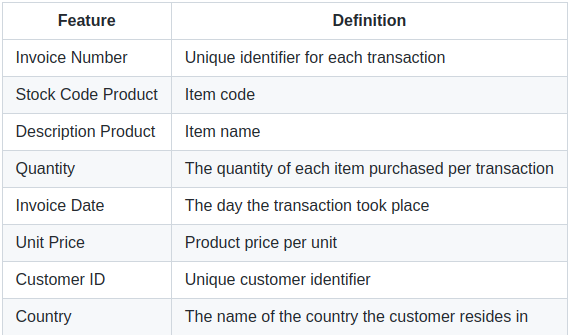

In [8]:
Image('../image/features_description.png')

### 1.2 Data Types

In [9]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

### 1.3 Check NA

In [10]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

### 1.4 Fillout NA

In [11]:
# Para avançar com o projeto de forma rápida, vamos retirar os registros com valores faltantes. 
# Posteriormente serão analisadas outras possibilidades de tratar esses dados.

df1 = df1.dropna(subset=['description', 'customer_id'])
print('Removed data: {:.0%}'.format( 1-(df1.shape[0] / df_raw.shape[0])))
print(f'New number of rows: {df1.shape[0]}')

Removed data: 25%
New number of rows: 406829


### 1.5 Change Types

In [12]:
df1['customer_id'] = df1['customer_id'].astype(int)
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'])

In [13]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

### 1.6 Descriptive Statistics

# 2. Feature Engineering

### 2.1 News Features

In [14]:
df2 = df1.copy()

In [15]:
# To run the RFM Model let's create Recency, Frequency and Monetery features:

# Data Reference
df_ref = df2.drop (['invoice_no', 'stock_code', 'description',
                    'quantity', 'invoice_date', 'unit_price',
                    'country'], axis=1).drop_duplicates(ignore_index=True)

# Recency
df_recency = df2[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on = 'customer_id', how = 'left')

# Frequency
df_freq = df2[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref, df_freq, on = 'customer_id', how = 'left')

# Monetary (Gross Revenue)
df2['gross_revenue'] = df2['quantity'] * df2['unit_price']
df_monetary = df2[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge (df_ref, df_monetary, on = 'customer_id', how = 'left')

# Avg Ticket
df_avg_ticket = df2[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id', how='left')

# 3. Data Filtering

In [16]:
df3 = df_ref.copy()

# 4. Exploratory Data Analysis

In [17]:
df4 = df3.copy()

# 5. Data Preparation

In [18]:
df5 = df4.copy()

# 6. Feature Selection

In [19]:
df6 = df5.copy()

# 7. Hyperparameter Fine-Tunning

### 7.0 Dataset

In [20]:
df6.head()

,customer_id,recency_days,invoice_no,gross_revenue,avg_ticket
0,17850,301,35,5288.63,16.950737
1,13047,31,18,3079.10,15.709694
2,12583,2,18,7187.34,28.634821
3,13748,95,5,948.25,33.866071
4,15100,329,6,635.10,105.850000


In [21]:
df7 = df6.drop(columns = ['customer_id'])

### 7.1 Within-Cluster Sum of Square (WSS)

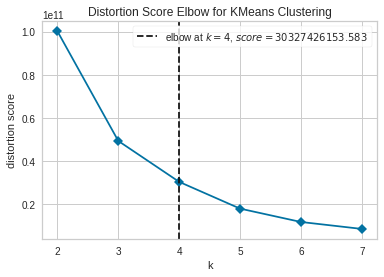

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [22]:
clusters = [2, 3, 4, 5, 6, 7]

# model definition
kmeans = KElbowVisualizer(c.KMeans(),
                          k = clusters,
                          timings = False)
# model training
kmeans.fit ( df7 )

# plot
kmeans.show()

### 7.2 Silhouette Score

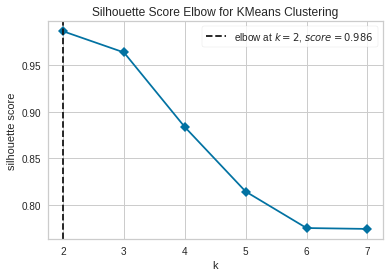

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [23]:
# Yellow Brick

# model definition
kmeans = KElbowVisualizer(c.KMeans(),
                          k = clusters,
                          metric='silhouette',
                          timings = False)

# model training
kmeans.fit ( df7 )

# plot
kmeans.show()

### 7.3 Silhouette Analysis

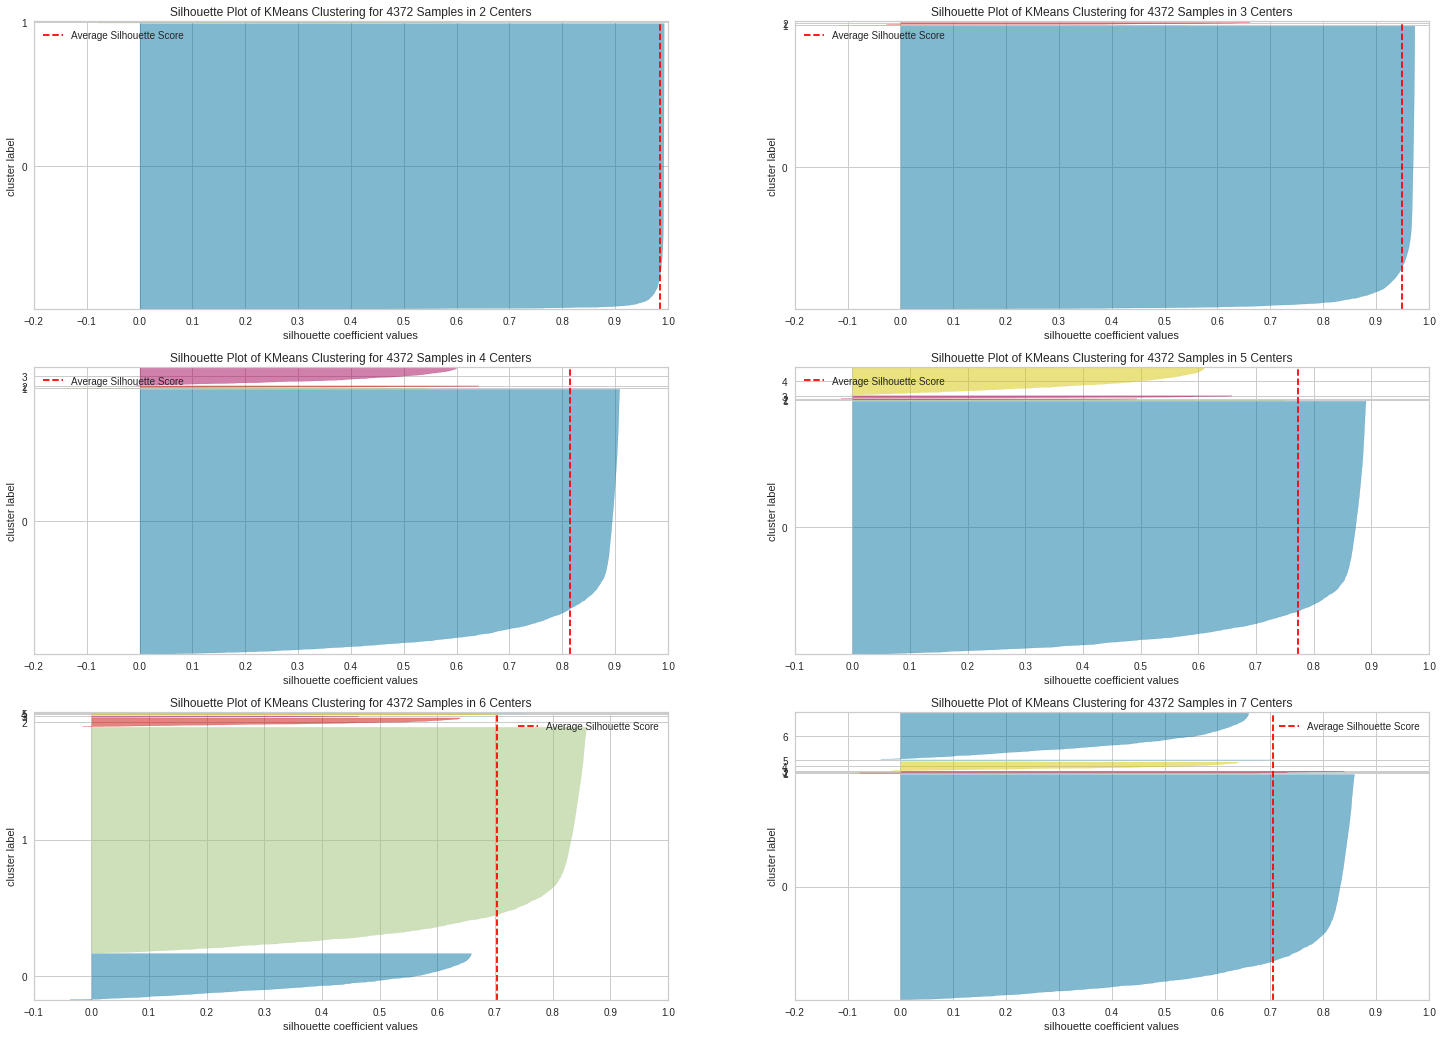

In [24]:
fig, ax = plt.subplots(3, 2, figsize=(25,18))

for k in clusters:
    km = c.KMeans(n_clusters=k,
                    init='random',
                    n_init=10,
                    max_iter=100,
                    random_state=42)
    q, mod = divmod(k, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(df7)
    visualizer.finalize()

# 8. Machine Learning Modelling

### 8.1 K-Means

In [25]:
X = df7.copy()

In [26]:
# model definition
k=4
kmeans = c.KMeans(init='random',
                  n_clusters=k,
                  n_init=10,
                  max_iter=300,
                  random_state=42)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

### 8.2 Cluster Validation

In [27]:
# WSS
print(f'WSS Value:{kmeans.inertia_}')

# SS
print('SS Value: {}'.format(m.silhouette_score(X, labels, metric='euclidean')))

WSS Value:40056504196.363365
SS Value: 0.8139969114940825


# 9. Evaluation - Cluster Analysis

### 9.1 Visualization Inspection

In [28]:
df9 = df6.copy()
df9['cluster'] = labels
df9.head()

,customer_id,recency_days,invoice_no,gross_revenue,avg_ticket,cluster
0,17850,301,35,5288.63,16.950737,3
1,13047,31,18,3079.10,15.709694,0
2,12583,2,18,7187.34,28.634821,3
3,13748,95,5,948.25,33.866071,0
4,15100,329,6,635.10,105.850000,0


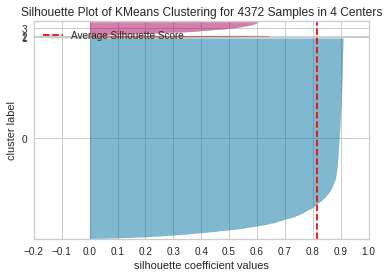

In [30]:
# Silhouette Viz:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

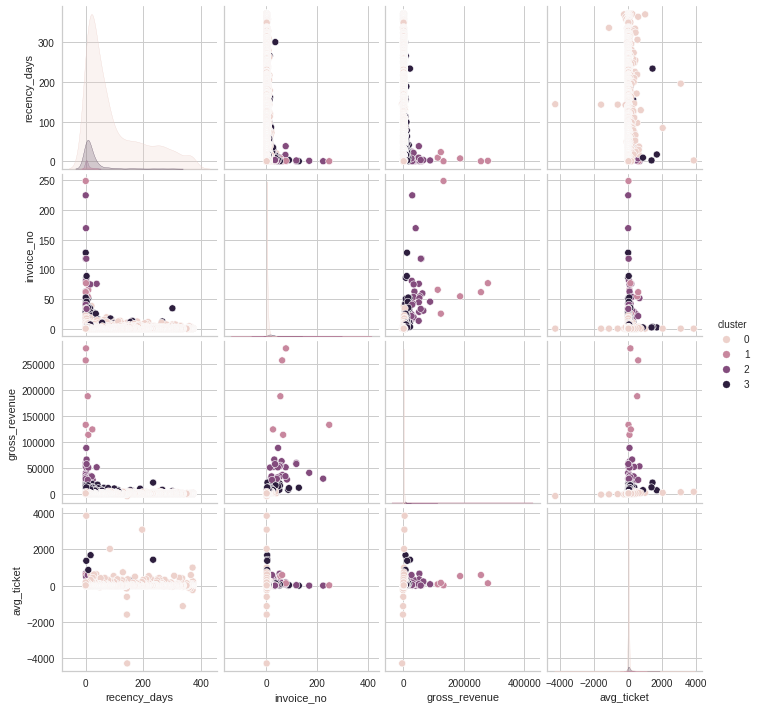

In [31]:
# 2D Plot (Pair Plot)
df_viz = df9.drop(columns='customer_id', axis=1)
sns.pairplot(df_viz, hue='cluster')

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

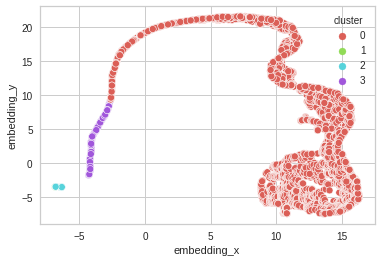

In [38]:
# UMAP (mais rápido para grandes quantidades de dados) / t-SNE (mais preciso, porém mais lento): 
    # abordagem por Manifold (topologia) - projeção de altas dimensões em 3D ou 2D sem perder suas características principais

reducer = umap.UMAP(n_neighbors=20, random_state=42)
embedding = reducer.fit_transform (X)

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plto UMAP
sns.scatterplot( x='embedding_x',
                 y='embedding_y',
                 hue='cluster',
                 palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())),
                 data = df_viz)

### 9.2 Cluster Profile

In [39]:
df9.head()

,customer_id,recency_days,invoice_no,gross_revenue,avg_ticket,cluster
0,17850,301,35,5288.63,16.950737,3
1,13047,31,18,3079.10,15.709694,0
2,12583,2,18,7187.34,28.634821,3
3,13748,95,5,948.25,33.866071,0
4,15100,329,6,635.10,105.850000,0


In [40]:
# Number of customer
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = (df_cluster['customer_id'] / df_cluster['customer_id'].sum())*100

# Avg gross revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on = 'cluster')

# Avg recency
df_avg_recency = df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency, how='inner', on='cluster')

# Avg invoice_no
df_avg_invoice_no = df9[['invoice_no', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_invoice_no, how='inner', on='cluster')

# Avg ticket
df_ticket = df9[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_ticket, how='inner', on='cluster')


df_cluster


,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,4071,93.115279,946.696250,96.429870,3.641120,25.359654
1,1,6,0.137237,182181.981667,6.666667,89.000000,253.626345
2,2,28,0.640439,42614.387143,5.678571,57.821429,162.862605
3,3,267,6.107045,8089.028652,19.823970,19.528090,62.783157


Cluster 01 (Candidado a Insider):
- Total Customers: 6 (0,14% of total)
- Avg Recency: 7 days
- Avg frequency: 89 purchase
- Avg Revenue: $ 182,181.98

Cluster 02:
- Total Customers: 31 (0,71% of total)
- Avg Recency: 14 days
- Avg frequency: 53 purchase
- Avg Revenue: $ 40,543.52

Cluster 03:
- Total Customers: 4,335 (99% of total)
- Avg Recency: 92 days
- Avg frequency: 5 purchase
- Avg Revenue: $ 1,372.58